In [22]:
# Modeling and Evaluation

## Objectives

Business Requirements # 2 - The clients wants to know if the cherry leaf in the picture is healthy or if it has powdery mildew.

## Inputs

* `/data/cherry-leaves/train`
* `/data/cherry-leaves/test`
* `/data/cherry-leaves/validation`

## Outputs

* Plot showing the distribution of images in the training, validation, and test sets.
* Implementation of image augmentation techniques to improve model robustness.
* Dictionary of class indices for prediction inference.
* Creation and training of a machine learning model for image classification.
* Model saved as `mildew_detection_model.keras`.
* Learning curve plot showing the training and validation accuracy and loss over epochs.
* Model evaluation pickle file containing metrics such as accuracy, precision, recall, and F1-score.
* Prediction result on a random image file, demonstrating the model's usage

# Import Libraries

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Rescaling, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

2025-03-05 08:34:09.852255: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 08:34:09.854058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 08:34:09.858138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 08:34:09.867752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741163649.884070   15757 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741163649.88

In [3]:
# Change working directory to project root
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory changed to: {os.getcwd()}")

Working directory changed to: /workspaces/mildew-detection-in-cherry-leaves


In [4]:
# Define data paths
train_path = "data/cherry-leaves/train"
val_path = "data/cherry-leaves/validation"
test_path = "data/cherry-leaves/test"

In [5]:
# Define output directory
root_dir = pathlib.Path(os.getcwd()).absolute()
version = 'v2'
file_path = os.path.join(root_dir, 'outputs', version)

# Create output directory if it doesn't exist
os.makedirs(file_path, exist_ok=True)

In [6]:
my_data_dir = 'data/cherry-leaves'
labels = ['healthy', 'powdery_mildew']

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 315 images
* validation - powdery_mildew: 315 images
* test - healthy: 317 images
* test - powdery_mildew: 317 images




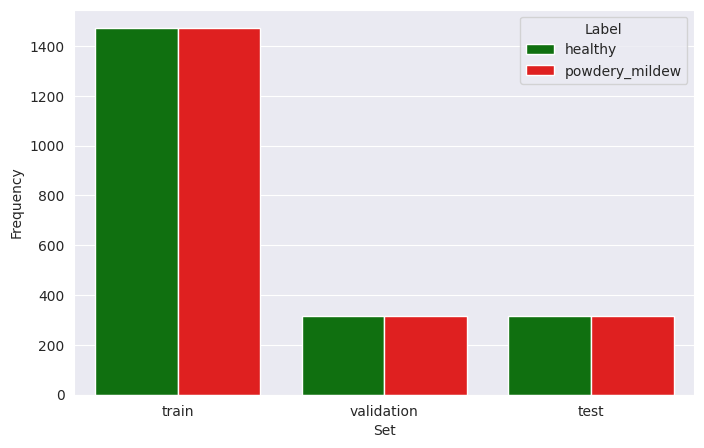

In [7]:
### Count images in train, validation, and test data

import pandas as pd
import seaborn as sns

# Initialize the DataFrame
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Count images in each set and for each label
for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        frequency = len(os.listdir(folder_path))

        new_row = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': frequency}])
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(f"* {folder} - {label}: {frequency} images")
print("\n")

# Set the style of the plot
sns.set_style("darkgrid")

# Define a custom color palette
palette = {"powdery_mildew": "red", "healthy": "green"}

# Generate the bar plot with the custom color palette
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=palette)

# Save and display the plot
plt.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
plt.show()

In [8]:
# Define image shape
image_shape = (100, 100, 3) # Per business requirement

In [9]:
# Image data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 15


In [10]:
# Load data from directories
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

validation_set = val_datagen.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


In [11]:
def create_tf_model(image_shape):
    """
    Creates a sequential model for binary image classification.
    """
    model = Sequential([
        Input(shape=image_shape),  
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    return model

In [12]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [13]:
# Create the model instance
model = create_tf_model(image_shape) 

2025-03-05 08:34:13.933698: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=train_set.samples // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop]
)


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.7209 - loss: 0.4902 - val_accuracy: 0.8968 - val_loss: 0.2544
Epoch 2/25
  1/196 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8667 - loss: 0.1578

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8667 - loss: 0.1578 - val_accuracy: 0.9000 - val_loss: 0.2456
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.9681 - loss: 0.0977 - val_accuracy: 0.9952 - val_loss: 0.0395
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 0.0175 - val_accuracy: 0.9968 - val_loss: 0.0332
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.9742 - loss: 0.0873 - val_accuracy: 0.9984 - val_loss: 0.0151
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.9984 - val_loss: 0.0148
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.9880 - loss: 0.0397 - val_accuracy: 0.9952 - val_loss: 0.0224
Epoch 8/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9952 - val_loss: 0.0270
Epoch 9/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - accuracy: 0.9917 - loss: 0.0275 - val_accuracy:

In [16]:
# Save the trained model
model.save(os.path.join(file_path, 'mildew_detection_model.keras'))

In [17]:
# Extract training metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")


Training Loss: [0.3409537076950073, 0.15775702893733978, 0.09018579870462418, 0.01749017834663391, 0.08965010195970535, 0.020043985918164253, 0.04127608239650726, 0.0017298046732321382, 0.036231983453035355]
Validation Loss: [0.2543719410896301, 0.24559767544269562, 0.0394938588142395, 0.03318479284644127, 0.015126376412808895, 0.01479499600827694, 0.02237113192677498, 0.02704145573079586, 0.01986510120332241]
Training Accuracy: [0.8361215591430664, 0.8666666746139526, 0.9696142077445984, 1.0, 0.9720041155815125, 1.0, 0.9866848587989807, 1.0, 0.9887333512306213]
Validation Accuracy: [0.89682537317276, 0.8999999761581421, 0.9952380657196045, 0.9968253970146179, 0.9984126687049866, 0.9984126687049866, 0.9952380657196045, 0.9952380657196045, 0.9968253970146179]


In [18]:
# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(file_path, "training_validation_loss.png"))
print(f"Training and validation loss plot saved to: {os.path.join(file_path, 'training_validation_loss.png')}") #Added print
plt.close()

Training and validation loss plot saved to: /workspaces/mildew-detection-in-cherry-leaves/outputs/v2/training_validation_loss.png


In [19]:
# Plot training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(file_path, "training_validation_accuracy.png"))
print(f"Training and validation accuracy plot saved to: {os.path.join(file_path, 'training_validation_accuracy.png')}") # Added print
plt.close()

Training and validation accuracy plot saved to: /workspaces/mildew-detection-in-cherry-leaves/outputs/v2/training_validation_accuracy.png


In [20]:
import os
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluation metrics
y_true = test_set.classes
y_pred_probs = model.predict(test_set)
y_pred = (y_pred_probs > 0.5).astype(int)

report = classification_report(y_true, y_pred, target_names=test_set.class_indices)
cm = confusion_matrix(y_true, y_pred)

evaluation = {
    'test_loss': loss,
    'test_accuracy': accuracy,
    'classification_report': report,
    'confusion_matrix': cm.tolist()
}
with open(os.path.join(file_path, 'evaluation.pkl'), 'wb') as f:
    pickle.dump(evaluation, f)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9973 - loss: 0.0269
Test Loss: 0.0195
Test Accuracy: 0.9984
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [21]:
# Random image prediction
import random

test_dir = 'data/cherry-leaves/test'
class_names = os.listdir(test_dir)
random_class = random.choice(class_names)
class_dir = os.path.join(test_dir, random_class)
image_files = os.listdir(class_dir)
random_image = random.choice(image_files)
image_path = os.path.join(class_dir, random_image)

img = image.load_img(image_path, target_size=image_shape[:2])
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
class_labels = {v: k for k, v in train_set.class_indices.items()}
predicted_class = class_labels[int(prediction[0][0] > 0.5)]

print(f"Image path: {image_path}")
print(f"Predicted class: {predicted_class}")
print(f"Actual Class: {random_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Image path: data/cherry-leaves/test/healthy/945405b7-e207-4cb2-a618-ac8a78c67c9f___JR_HL 9653_flipTB.JPG
Predicted class: healthy
Actual Class: healthy
